In [3]:
from pyspark.sql import SparkSession, DataFrame, Column, Row
from pyspark.sql.types import IntegerType

In [4]:
builder = SparkSession.builder \
    .appName("Basic Cardinality Estimation") \
    .config("spark.sql.cbo.enabled", True) \
    .config("spark.master", "local[*]") \
    .config("spark.sql.cbo.joinReorder.enabled", True) \
    .config("spark.sql.cbo.joinReorder.dp.threshold", 16) \
    .config("spark.sql.statistics.histogram.enabled", True) \
    .config("spark.sql.statistics.histogram.numBins", 25) \
    .enableHiveSupport()

spark = builder.getOrCreate()

In [5]:
import pandas as pd
import numpy as np

In [6]:
def get_uniform_ints_df(max_val):
    """Returns a single column dataframe of 500 integers sampled uniformly from [0,50)"""
    pd_df = pd.DataFrame(np.random.randint(0,max_val,[500], np.int))
    df = spark.createDataFrame(pd_df, ["x"])
    return df

def create_uniform_tables():
    """Creates 4 tables with single column of uniform distribution and computes table and column statistics"""
    table_names = ["A", "B", "C", "D"]
    for i in range(4):
        table_name = table_names[i]
        df = get_uniform_ints_df(25*(i+1))
        df.write.mode("overwrite").saveAsTable(table_name)
        spark.sql("Analyze Table " + table_name + " compute statistics")
        spark.sql("Analyze Table " + table_name + " compute statistics for columns " + "x")
        spark.sql("Describe extended " + table_name).show();
    

In [373]:
create_uniform_tables()

+--------------------+--------------------+-------+
|            col_name|           data_type|comment|
+--------------------+--------------------+-------+
|                   x|              bigint|   null|
|                    |                    |       |
|# Detailed Table ...|                    |       |
|            Database|             default|       |
|               Table|                   a|       |
|               Owner|        amogkamsetty|       |
|        Created Time|Fri Nov 30 19:17:...|       |
|         Last Access|Thu Jan 01 00:00:...|       |
|          Created By|         Spark 2.4.0|       |
|                Type|             MANAGED|       |
|            Provider|             parquet|       |
|    Table Properties|[transient_lastDd...|       |
|          Statistics|2560 bytes, 500 rows|       |
|            Location|file:/mnt/c/Users...|       |
|       Serde Library|org.apache.hadoop...|       |
|         InputFormat|org.apache.hadoop...|       |
|        Out

In [374]:
stats = {}
stats["A"] = spark.sql("describe extended A x").rdd.collectAsMap()
stats["B"] = spark.sql("describe extended B x").rdd.collectAsMap()
stats["C"] = spark.sql("describe extended C x").rdd.collectAsMap()
stats["D"] = spark.sql("describe extended D x").rdd.collectAsMap()

In [375]:
result = spark.sql("Select * from D where D.x > 25")
print(result._jdf.queryExecution().optimizedPlan().stats().rowCount().get())
print(result.count())
stats["A"]

375
371


{'avg_col_len': '8',
 'bin_0': 'lower_bound: 0.0, upper_bound: 0.0, distinct_count: 1',
 'bin_1': 'lower_bound: 0.0, upper_bound: 2.0, distinct_count: 2',
 'bin_10': 'lower_bound: 10.0, upper_bound: 11.0, distinct_count: 1',
 'bin_11': 'lower_bound: 11.0, upper_bound: 12.0, distinct_count: 1',
 'bin_12': 'lower_bound: 12.0, upper_bound: 13.0, distinct_count: 1',
 'bin_13': 'lower_bound: 13.0, upper_bound: 13.0, distinct_count: 1',
 'bin_14': 'lower_bound: 13.0, upper_bound: 14.0, distinct_count: 1',
 'bin_15': 'lower_bound: 14.0, upper_bound: 15.0, distinct_count: 1',
 'bin_16': 'lower_bound: 15.0, upper_bound: 16.0, distinct_count: 1',
 'bin_17': 'lower_bound: 16.0, upper_bound: 17.0, distinct_count: 1',
 'bin_18': 'lower_bound: 17.0, upper_bound: 18.0, distinct_count: 1',
 'bin_19': 'lower_bound: 18.0, upper_bound: 20.0, distinct_count: 2',
 'bin_2': 'lower_bound: 2.0, upper_bound: 3.0, distinct_count: 1',
 'bin_20': 'lower_bound: 20.0, upper_bound: 20.0, distinct_count: 1',
 'bin_21

## Graph Nets

In [376]:
import collections
import time

from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools

In [377]:
SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)
table_names = ["A", "B", "C", "D"]
node_features = {}
operators = ["=", "<", ">", "<=", ">="]

In [378]:
def featurize_col_stats():
    for table_name, column_stats in stats.items():
        row_count = spark.sql("select * from "+table_name).count()
        feature = [row_count, \
                   column_stats['distinct_count'], \
                   column_stats['num_nulls'], \
                   column_stats['min'], \
                   column_stats['max'], \
                  column_stats['avg_col_len'], \
                  column_stats['max_col_len']]
        feature_np = np.asarray(feature, dtype=np.float32)
        #node_features[table_name] = tf.convert_to_tensor(feature_np, dtype=tf.float32) 
        node_features[table_name] = feature

In [379]:
featurize_col_stats()
node_features

{'A': [500, '25', '0', '0', '24', '8', '8'],
 'B': [500, '52', '0', '0', '49', '8', '8'],
 'C': [500, '76', '0', '0', '74', '8', '8'],
 'D': [500, '101', '0', '0', '99', '8', '8']}

In [380]:
def create_graph_dicts(rand, num_examples, selectivity=True):
    """Generates the input and target graphs for training.
        Returns an array of input_graphs with featurized nodes
        Without selectivity, 4 choose 2 = 6 possible graphs
        With selectivity, generate 2 tables, and create a random selectivity on one of them
        
        Returns data dictionaries"""
    input_graphs = []
    estimated_cards = []
    if not selectivity:
        #Do not want to use selectivity when generating samples
        #Total of 6 input graphs, ignore num_examples
        for combo in list(itertools.combinations(range(4), 2)):
            table1_name = table_names[combo[0]]
            table2_name = table_names[combo[1]]
            table1_features = [float(x) for x in node_features[table1_name]]
            table2_features = [float(x) for x in node_features[table2_name]]
            input_graphs.append({"nodes": [table1_features, table2_features], "receivers": [0, 1], "senders": [1, 0], "edges": [[0.0], [0.0]], "globals": [0.0]})
            cardinality = spark.sql("select * from "+table1_name+","+table2_name+" where "+table1_name+".x = "+table2_name+".x") \
                .count()
            estimated_cards.append(cardinality)
        return input_graphs, estimated_cards
    else:
        #randomly generate num_examples number of 2 table joins with selections
        for _ in range(num_examples):
            #Randomly select 2 tables, and randomly generate selectivities
            #tables = np.random.choice(table_names, size=2, replace=False)
            tables = rand.choice(table_names, size=2, replace=False)
            table1_name = tables[0]
            table2_name = tables[1]
            #table1_name = tf.gather(tables, 0)
            #table2_name = tf.gather(tables, 1)
            #print(table1_name, table2_name)
            table1_features = [float(x) for x in node_features[table1_name]]
            table2_features = [float(x) for x in node_features[table2_name]]
            #operator = np.random.choice(operators)
            operator = rand.choice(operators)
            #val = np.random.randint(int(stats[table1_name]['max'])+1)
            val = rand.randint(int(stats[table1_name]['max'])+1)
            #print(operator, val)
            query_result = spark.sql("Select * from "+ table1_name + " where "+table1_name+".x "+operator+" "+str(val))
            predicted_size = [query_result._jdf.queryExecution().optimizedPlan().stats().rowCount().get()]
            #table1_features = tf.concat([table1_features, predicted_size], 0)
            #table2_features = tf.concat([table2_features, [table2_features[0]]], 0)
            #table1_features = np.append(table1_features, [predicted_size])
            #table2_features = np.append(table2_features, [table2_features[0]])
            table1_features = table1_features + predicted_size
            table2_features = table2_features + [table2_features[0]]
            input_graphs.append({"nodes": [table1_features, table2_features], "receivers": [0, 1], "senders": [1, 0], "edges": [[0.0], [0.0]], "globals": [0.0]})
            cardinality = spark.sql("select * from "+table1_name+","+table2_name+" where "+table1_name+".x = "+table2_name+".x " \
                                   "AND "+table1_name+".x "+operator+" "+str(val)).count()
            estimated_cards.append(cardinality)
        return input_graphs, estimated_cards

def create_target_dicts(batch_size, input_dicts, estimated_cards):
    target_dicts = []
    for i in range(batch_size):
        cardinality = estimated_cards[i]
        edges = [[cardinality], [cardinality]]
        target_dict = input_dicts[i].copy()
        target_dict['nodes'] = None
        target_dict['edges'] = edges
        target_dicts.append(target_dict)
    return target_dicts
# def create_target_graphs(batch_size, input_graphs, estimated_cards):
#     target_graphs = []
#     for i in range(batch_size):
#         input_graph = utils_tf.get_graph(input_graphs, i)
#         cardinality = estimated_cards[i]
#         #table1 = relation_tuples[i][0]
#         #table2 = relation_tuples[i][1]
#         #cardinality = spark.sql("select * from "+table1+","+table2+" where "+table1+".x = "+table2+".x").count()
#         num_edges = input_graph.n_edge
#         edges = tf.constant([[cardinality], [cardinality]])
#         #edges = [[cardinality], [cardinality]]
#         target_graphs.append(input_graph._replace(edges=edges, nodes=None))
#     return utils_tf.concat(target_graphs, axis=0)
#     #return target_graphs


def create_data_ops(rand, batch_size, selectivity=True):
    if selectivity:
        inputs_op, estimated_cards = create_graph_dicts(rand, batch_size, True)
        targets_op = create_target_dicts(batch_size, inputs_op, estimated_cards)
        #inputs_op = utils_tf.data_dicts_to_graphs_tuple(inputs_op)
        #inputs_op = utils_tf.set_zero_edge_features(inputs_op, 1)
        #inputs_op = utils_tf.set_zero_global_features(inputs_op, 1)
        
    else:
        #ignore batch_size
        inputs_op, estimated_cards = create_graph_dicts(rand, 6, False)
        targets_op = create_target_dicts(6, inputs_op, estimated_cards)
        #inputs_op = utils_tf.data_dicts_to_graphs_tuple(inputs_op)
        #inputs_op = utils_tf.set_zero_edge_features(inputs_op, 1)
        #inputs_op = utils_tf.set_zero_global_features(inputs_op, 1)
    
    
    return inputs_op, targets_op

def create_placeholders(rand, batch_size, selectivity=True):
    """Creates placeholders for the model training and evaluation"""
    input_graphs, target_graphs = create_data_ops(rand, batch_size, selectivity)
    #input_graphs = utils_tf.data_dicts_to_graphs_tuple(input_graphs)
    #input_graphs = utils_tf.set_zero_edge_features(input_graphs, 1)
    #input_graphs = utils_tf.set_zero_global_features(input_graphs, 1)
    input_ph = utils_tf.placeholders_from_data_dicts(input_graphs, force_dynamic_num_graphs=True)
    #input_ph = utils_tf._placeholders_from_graphs_tuple(input_graphs, force_dynamic_num_graphs=True)
    target_ph = utils_tf.placeholders_from_data_dicts(target_graphs, force_dynamic_num_graphs=True)
    #target_graphs = utils_tf.data_dicts_to_graphs_tuple(target_graphs)
    #target_graphs = utils_tf.set_zero_node_features(target_graphs, 1)
    #target_graphs = utils_tf.set_zero_global_features(target_graphs, 1)
    #target_ph = utils_tf._placeholders_from_graphs_tuple(target_graphs, force_dynamic_num_graphs=True)
    return input_ph, target_ph

def create_feed_dict(rand, batch_size, selectivity, input_ph, target_ph):
    inputs_graphs, target_graphs = create_data_ops(rand, batch_size, selectivity)
#     inputs_op_tf, targets_op_tf = make_all_runnable_in_session(inputs_op_tf, targets_op_tf)
#     inputs_graphs, targets_graphs = sess.run([inputs_op_tf, targets_op_tf])
    input_graphs = utils_np.data_dicts_to_graphs_tuple(inputs_graphs)
    #n_edges = np.sum(input_graphs.n_edge, axis=0)
    #n_graphs = input_graphs.n_node.shape[0]
    #input_graphs = utils_tf.set_zero_edge_features(input_graphs, 1)
    #input_graphs = utils_tf.set_zero_global_features(input_graphs, 1)
    target_graphs = utils_np.data_dicts_to_graphs_tuple(target_graphs)
    #target_graphs = utils_tf.set_zero_node_features(target_graphs, 1)
    #feed_dict = {input_ph: input_graphs, target_ph: target_graphs}
    #print(input_ph)
    feed_dict_input = utils_tf.get_feed_dict(input_ph, input_graphs)
    feed_dict_target = utils_tf.get_feed_dict(target_ph, target_graphs)
    feed_dict = {**feed_dict_input, **feed_dict_target}
    return feed_dict

def make_all_runnable_in_session(*args):
    return [utils_tf.make_runnable_in_session(a) for a in args]
        
        

In [381]:
#tf.reset_default_graph()
seed = 1  #@param{type: 'integer'}
rand = np.random.RandomState(seed=seed)
inputs_op_tf, targets_op_tf = create_data_ops(rand, 3, True)
inputs_op_tf, targets_op_tf

([{'edges': [[0.0], [0.0]],
   'globals': [0.0],
   'nodes': [[500.0, 101.0, 0.0, 0.0, 99.0, 8.0, 8.0, 373],
    [500.0, 76.0, 0.0, 0.0, 74.0, 8.0, 8.0, 500.0]],
   'receivers': [0, 1],
   'senders': [1, 0]},
  {'edges': [[0.0], [0.0]],
   'globals': [0.0],
   'nodes': [[500.0, 101.0, 0.0, 0.0, 99.0, 8.0, 8.0, 376],
    [500.0, 76.0, 0.0, 0.0, 74.0, 8.0, 8.0, 500.0]],
   'receivers': [0, 1],
   'senders': [1, 0]},
  {'edges': [[0.0], [0.0]],
   'globals': [0.0],
   'nodes': [[500.0, 76.0, 0.0, 0.0, 74.0, 8.0, 8.0, 320],
    [500.0, 25.0, 0.0, 0.0, 24.0, 8.0, 8.0, 500.0]],
   'receivers': [0, 1],
   'senders': [1, 0]}],
 [{'edges': [[2470], [2470]],
   'globals': [0.0],
   'nodes': None,
   'receivers': [0, 1],
   'senders': [1, 0]},
  {'edges': [[2470], [2470]],
   'globals': [0.0],
   'nodes': None,
   'receivers': [0, 1],
   'senders': [1, 0]},
  {'edges': [[3383], [3383]],
   'globals': [0.0],
   'nodes': None,
   'receivers': [0, 1],
   'senders': [1, 0]}])

In [382]:
input_ph, target_ph = create_placeholders(rand, 3, True)
input_out, target_out = make_all_runnable_in_session(input_ph, target_ph)
#print(input_ph, target_ph)

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    feed_dict = create_feed_dict(rand, 3, True, input_ph, target_ph)
    #print(feed_dict)
    inputs_graphs, targets_graphs = sess.run([input_out, target_out], feed_dict=feed_dict)
    print("Input Graphs: ",inputs_graphs)
    print("Target Graphs: ", targets_graphs)

Input Graphs:  GraphsTuple(nodes=array([[ 500.,   52.,    0.,    0.,   49.,    8.,    8.,   94.],
       [ 500.,   25.,    0.,    0.,   24.,    8.,    8.,  500.],
       [ 500.,   76.,    0.,    0.,   74.,    8.,    8.,    5.],
       [ 500.,   25.,    0.,    0.,   24.,    8.,    8.,  500.],
       [ 500.,   76.,    0.,    0.,   74.,    8.,    8.,    5.],
       [ 500.,   52.,    0.,    0.,   49.,    8.,    8.,  500.]], dtype=float32), edges=array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]], dtype=float32), receivers=array([0, 1, 2, 3, 4, 5], dtype=int32), senders=array([1, 0, 3, 2, 5, 4], dtype=int32), globals=array([[ 0.],
       [ 0.],
       [ 0.]], dtype=float32), n_node=array([2, 2, 2], dtype=int32), n_edge=array([2, 2, 2], dtype=int32))
Target Graphs:  GraphsTuple(nodes=None, edges=array([[1749],
       [1749],
       [ 156],
       [ 156],
       [  44],
       [  44]], dtype=int32), receivers=array([0, 1, 0, 1, 0, 1], dtype=int32), senders=arr

In [383]:
spark.sql("select * from B, C where B.x < 42 and B.x=C.x").count()

2714

In [384]:
def compute_accuracy(target, output):
    """Computes symmetric mean absolute percentage error and solved accuracy of the final graph. Returns fraction of correctly solved cardinalities
    
        Target is the target graph
        Output is the output graph"""
    target_dicts = utils_np.graphs_tuple_to_data_dicts(target)
    output_dicts = utils_np.graphs_tuple_to_data_dicts(output)
    percent_difference = []
    correctly_solved = []
    for td, od in zip(target_dicts, output_dicts):
        #predicted1 = od['edges'][0]
        #predicted2 = od['edges'][1]
        #actual1 = td['edges'][0]
        #actual2 = td['edges'][1]
        #num_edges = td['edges'].shape[0]
        is_equal = np.equal(od['edges'], td['edges'])
        numerator = np.absolute(od['edges']-td['edges'])
        denom = np.absolute(od['edges']) + np.absolute(td['edges'])
        #numerator = np.where(is_equal, [0, 0], numerator)
        denom = np.where(is_equal, [1, 1], denom)
        pd = np.mean(np.divide(numerator, denom))
        #pd = np.mean(np.divide(np.absolute(od['edges']-td['edges']), np.absolute(td['edges']) + np.absolute(od['edges'])))
        percent_difference.append(pd)
        correctly_solved.append(np.equal(np.round(np.mean(od['edges'])), np.mean(td['edges'])))
    correct = np.mean(correctly_solved)
    pd = np.mean(percent_difference)
    return pd, correct

def create_loss_ops(target_op, output_ops):
    if not isinstance(output_ops, collections.Sequence):
        output_ops = [output_ops]
    
    loss_ops = [
        tf.losses.mean_squared_error(target_op.edges, output_op.edges) for output_op in output_ops
    ]
    
    return loss_ops
    

## Training

In [385]:
#tf.reset_default_graph()

seed = 2
rand = np.random.RandomState(seed=seed)

num_processing_steps_tr = 10
num_processing_steps_ge = 10

num_training_iterations = 25000
batch_size_tr = 32
batch_size_ge = 100

# inputs_op_tr, targets_op_tr = create_data_ops(
#     batch_size_tr, True)
# inputs_op_tr = utils_tf.set_zero_edge_features(inputs_op_tr, 1)
# inputs_op_tr = utils_tf.set_zero_global_features(inputs_op_tr, 1)

# inputs_op_ge, targets_op_ge = create_data_ops(
#     batch_size_ge, True)
# inputs_op_ge = utils_tf.set_zero_edge_features(inputs_op_ge, 1)
# inputs_op_ge = utils_tf.set_zero_global_features(inputs_op_ge, 1)

input_ph, target_ph = create_placeholders(rand, batch_size_tr, True)
#input_ph = utils_tf.set_zero_edge_features(input_ph, 1)
#input_ph = utils_tf.set_zero_global_features(input_ph, 1)

# Instantiate the model.
model = models.EncodeProcessDecode(edge_output_size=1, node_output_size=None)
# A list of outputs, one per processing step.
output_ops_tr = model(input_ph, num_processing_steps_tr)
output_ops_ge = model(input_ph, num_processing_steps_ge)

# Loss.
loss_ops_tr = create_loss_ops(target_ph, output_ops_tr)
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr  # loss_ops_tr
loss_ops_ge = create_loss_ops(target_ph, output_ops_ge)
loss_op_ge = loss_ops_ge[-1]

# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

# Lets an iterable of TF graphs be output from a session as NP graphs.
# inputs_op_tr, targets_op_tr = make_all_runnable_in_session(
#     inputs_op_tr, targets_op_tr)
# inputs_op_ge, targets_op_ge = make_all_runnable_in_session(
#     inputs_op_ge, targets_op_ge)

input_out, target_out = make_all_runnable_in_session(input_ph, target_ph)


/home/amogkamsetty/anaconda3/envs/env_full_py3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [386]:
# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
  sess.close()
except NameError:
  pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []

In [387]:
# How much time between logging and printing the current results.
log_every_seconds = 20

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (test/generalization loss), "
      "Ctr (training fraction nodes/edges labeled correctly), "
      "Str (training fraction examples solved correctly), "
      "Cge (test/generalization fraction nodes/edges labeled correctly), "
      "Sge (test/generalization fraction examples solved correctly)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  feed_dict = create_feed_dict(rand, batch_size_tr, True, input_ph, target_ph)
#   input_graphs, target_graphs = create_data_ops(rand, batch_size_tr, True)
#   input_graphs, target_graphs = sess.run([input_graphs, target_graphs])
#   feed_dict = {input_ph: input_graphs, target_ph: target_graphs}
  train_values = sess.run({
      "step": step_op,
      "inputs": input_out,
      "targets": target_out,
      "loss": loss_op_tr,
      "outputs": output_ops_tr
  }, feed_dict = feed_dict)
  #print("Input Graphs: ",train_values["inputs"])
  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if elapsed_since_last_log > log_every_seconds:
    last_log_time = the_time
    feed_dict = create_feed_dict(
        rand, batch_size_ge, True, input_ph, target_ph)
    test_values = sess.run({
        "targets": target_out,
        "loss": loss_op_ge,
        "outputs": output_ops_ge,
    }, feed_dict=feed_dict)
    #print(train_values["targets"])
    #print(train_values["outputs"])
    pd_tr, correct_tr = compute_accuracy(train_values["targets"],
                                             train_values["outputs"][-1])
    pd_ge, correct_ge = compute_accuracy(test_values["targets"],
                                             test_values["outputs"][-1])
    elapsed = time.time() - start_time
    losses_tr.append(train_values["loss"])
    corrects_tr.append(pd_tr)
    solveds_tr.append(correct_tr)
    losses_ge.append(test_values["loss"])
    solveds_ge.append(correct_ge)
    corrects_ge.append(pd_ge)
    logged_iterations.append(iteration)
    print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f}, Pdtr {:.4f}, "
          "Ctr {:.4f}, Pdge {:.4f}, Cge {:.4f}".format(
              iteration, elapsed, train_values["loss"], test_values["loss"],
              pd_tr, correct_tr, pd_ge, correct_ge))

# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (test/generalization loss), Ctr (training fraction nodes/edges labeled correctly), Str (training fraction examples solved correctly), Cge (test/generalization fraction nodes/edges labeled correctly), Sge (test/generalization fraction examples solved correctly)
# 00001, T 50.2, Ltr 4849508.0000, Lge 2908920.2500, Pdtr 0.9991, Ctr 0.1562, Pdge 0.9983, Cge 0.1300
# 00002, T 76.3, Ltr 3777475.2500, Lge 2861543.0000, Pdtr 0.9990, Ctr 0.0938, Pdge 0.9974, Cge 0.0700
# 00003, T 101.6, Ltr 3975669.2500, Lge 3185328.2500, Pdtr 0.9974, Ctr 0.2500, Pdge 0.9983, Cge 0.2200
# 00004, T 126.9, Ltr 1538219.3750, Lge 3080652.2500, Pdtr 0.9971, Ctr 0.1250, Pdge 0.9979, Cge 0.1300
# 00005, T 152.6, Ltr 3908976.7500, Lge 2634314.0000, Pdtr 0.9988, Ctr 0.1875, Pdge 0.9947, Cge 0.1700
# 00006, T 178.8, Ltr 2504655.7500, Lge 3115052.7500, Pdtr 0.9981, Ctr 0.2500, Pdge 0.9950, Cge 0.1000
# 00007, T 203.9, Ltr 2133226.2500, Lge 3080482.0000, P

Py4JJavaError: An error occurred while calling o33653.count.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:226)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec.doExecuteBroadcast(BroadcastExchangeExec.scala:146)
	at org.apache.spark.sql.execution.InputAdapter.doExecuteBroadcast(WholeStageCodegenExec.scala:370)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeBroadcast$1.apply(SparkPlan.scala:144)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeBroadcast$1.apply(SparkPlan.scala:140)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.executeBroadcast(SparkPlan.scala:140)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.prepareBroadcast(BroadcastHashJoinExec.scala:136)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.codegenInner(BroadcastHashJoinExec.scala:234)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.doConsume(BroadcastHashJoinExec.scala:103)
	at org.apache.spark.sql.execution.CodegenSupport$class.constructDoConsumeFunction(WholeStageCodegenExec.scala:211)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:182)
	at org.apache.spark.sql.execution.ProjectExec.consume(basicPhysicalOperators.scala:35)
	at org.apache.spark.sql.execution.ProjectExec.doConsume(basicPhysicalOperators.scala:65)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:184)
	at org.apache.spark.sql.execution.FilterExec.consume(basicPhysicalOperators.scala:85)
	at org.apache.spark.sql.execution.FilterExec.doConsume(basicPhysicalOperators.scala:206)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:184)
	at org.apache.spark.sql.execution.FileSourceScanExec.consume(DataSourceScanExec.scala:159)
	at org.apache.spark.sql.execution.ColumnarBatchScan$class.produceBatches(ColumnarBatchScan.scala:144)
	at org.apache.spark.sql.execution.ColumnarBatchScan$class.doProduce(ColumnarBatchScan.scala:83)
	at org.apache.spark.sql.execution.FileSourceScanExec.doProduce(DataSourceScanExec.scala:159)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.FileSourceScanExec.produce(DataSourceScanExec.scala:159)
	at org.apache.spark.sql.execution.FilterExec.doProduce(basicPhysicalOperators.scala:125)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.FilterExec.produce(basicPhysicalOperators.scala:85)
	at org.apache.spark.sql.execution.ProjectExec.doProduce(basicPhysicalOperators.scala:45)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.ProjectExec.produce(basicPhysicalOperators.scala:35)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.doProduce(BroadcastHashJoinExec.scala:98)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.produce(BroadcastHashJoinExec.scala:40)
	at org.apache.spark.sql.execution.ProjectExec.doProduce(basicPhysicalOperators.scala:45)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.ProjectExec.produce(basicPhysicalOperators.scala:35)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.doProduceWithoutKeys(HashAggregateExec.scala:238)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.doProduce(HashAggregateExec.scala:164)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.produce(HashAggregateExec.scala:40)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doCodeGen(WholeStageCodegenExec.scala:527)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:581)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.prepareShuffleDependency(ShuffleExchangeExec.scala:92)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:128)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:374)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.inputRDDs(HashAggregateExec.scala:151)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:610)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:247)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:296)
	at org.apache.spark.sql.Dataset$$anonfun$count$1.apply(Dataset.scala:2831)
	at org.apache.spark.sql.Dataset$$anonfun$count$1.apply(Dataset.scala:2830)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3365)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3364)
	at org.apache.spark.sql.Dataset.count(Dataset.scala:2830)
	at sun.reflect.GeneratedMethodAccessor266.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 17687.0 failed 1 times, most recent failure: Lost task 2.0 in stage 17687.0 (TID 52983, localhost, executor driver): java.io.FileNotFoundException: File file:/mnt/c/Users/abc/Documents/research/sparksql-graph/spark-warehouse/d/part-00001-3f13e99e-4089-42bb-997c-afc00389c12a-c000.snappy.parquet does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:177)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:101)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.scan_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:619)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollectIterator(SparkPlan.scala:306)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec$$anonfun$relationFuture$1$$anonfun$apply$1.apply(BroadcastExchangeExec.scala:79)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec$$anonfun$relationFuture$1$$anonfun$apply$1.apply(BroadcastExchangeExec.scala:76)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withExecutionId$1.apply(SQLExecution.scala:101)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withExecutionId(SQLExecution.scala:98)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec$$anonfun$relationFuture$1.apply(BroadcastExchangeExec.scala:75)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec$$anonfun$relationFuture$1.apply(BroadcastExchangeExec.scala:75)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.io.FileNotFoundException: File file:/mnt/c/Users/abc/Documents/research/sparksql-graph/spark-warehouse/d/part-00001-3f13e99e-4089-42bb-997c-afc00389c12a-c000.snappy.parquet does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:177)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:101)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.scan_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:619)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	... 3 more


Text(0,0.5,'Fraction examples solved')

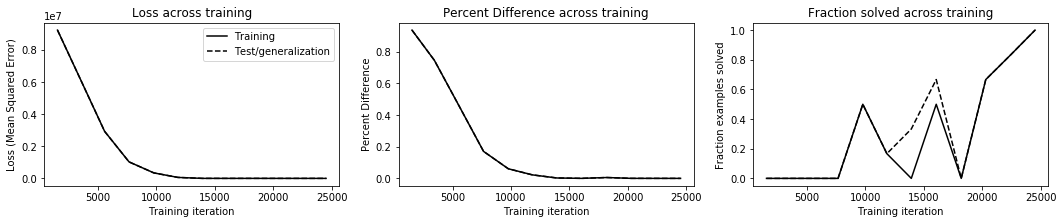

In [65]:
# This cell visualizes the results of training. You can visualize the
# intermediate results by interrupting execution of the cell above, and running
# this cell. You can then resume training by simply executing the above cell
# again.

# Plot results curves.
fig = plt.figure(11, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Loss.
y_tr = losses_tr
y_ge = losses_ge
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Loss across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Loss (Mean Squared Error)")
ax.legend()
# Correct.
y_tr = corrects_tr
y_ge = corrects_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("SMAPE across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("SMAPE")
# Solved.
y_tr = solveds_tr
y_ge = solveds_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction solved across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction examples solved")

In [66]:
final_train_output = utils_np.graphs_tuple_to_data_dicts(train_values['outputs'][-1])
final_target = utils_np.graphs_tuple_to_data_dicts(train_values['targets'])
for out, target in zip(final_train_output, final_target):
    print("Output: ",out['edges'])
    print("Target: ", target['edges'])

Output:  [[ 4693.93652344]
 [ 4693.97558594]]
Target:  [[4694]
 [4694]]
Output:  [[ 3382.97216797]
 [ 3382.95166016]]
Target:  [[3383]
 [3383]]
Output:  [[ 2411.68725586]
 [ 2412.00805664]]
Target:  [[2412]
 [2412]]
Output:  [[ 3184.92895508]
 [ 3185.14599609]]
Target:  [[3185]
 [3185]]
Output:  [[ 2572.04199219]
 [ 2572.03466797]]
Target:  [[2572]
 [2572]]
Output:  [[ 2470.62939453]
 [ 2469.24609375]]
Target:  [[2470]
 [2470]]
